In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('data/df.csv', index_col=0)
df = df.sort_values(by='date')
df.shape

(226486, 5)

In [26]:
# Generate features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['day_of_year'] = df['date'].dt.dayofyear

# encode categories
df_categories = pd.get_dummies(df['category_id'])
df_categories.columns = ['category_1', 'category_2', 'category_3']
df = pd.concat([df, df_categories], axis=1).drop('category_id', axis=1)

# calculate growing sums
df['growing_sum_sales_quantity'] = df.groupby('sku_id')['sales_quantity'].cumsum()

# calculate yield
df['yield'] = df['sales_price'] * df['sales_quantity']
df['growing_sum_yield'] = df.groupby('sku_id')['yield'].cumsum()

df

,date,sku_id,sales_price,sales_quantity,year,month,day,day_of_year,category_1,category_2,category_3,growing_sum_sales_quantity,yield,growing_sum_yield
249598,2016-11-18,415510,23.205,1.0,2016,11,18,323,0,1,0,1.0,23.205,23.205
249608,2016-11-18,420009,22.490,2.0,2016,11,18,323,0,1,0,2.0,44.980,44.980
714145,2016-11-18,567734,23.205,1.0,2016,11,18,323,0,1,0,1.0,23.205,23.205
699986,2016-11-18,556333,32.760,2.0,2016,11,18,323,0,1,0,2.0,65.520,65.520
683507,2016-11-18,566241,283.400,1.0,2016,11,18,323,1,0,0,1.0,283.400,283.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20699585,2020-10-31,458375,349.700,1.0,2020,10,31,305,1,0,0,111.0,349.700,39610.350
20699624,2020-10-31,487116,388.700,1.0,2020,10,31,305,1,0,0,164.0,388.700,57280.600
20699682,2020-10-31,132689,356.200,1.0,2020,10,31,305,1,0,0,356.0,356.200,116046.086
20688487,2020-10-31,621322,54.600,1.0,2020,10,31,305,0,1,0,1979.0,54.600,59771.465


In [27]:
dates = pd.date_range(start='2022-01-01', end='2022-12-31')

# Create a pandas Series with dates
date_series = pd.Series(dates)

# Define a list of holidays
ukrainian_holidays = [
    '2022-01-01',  # New Year's Day
    '2022-01-07',  # Orthodox Christmas Day
    '2022-03-08',  # International Women's Day
    '2022-04-17',  # Orthodox Easter Sunday
    '2022-04-18',  # Orthodox Easter Monday
    '2022-05-01',  # International Workers' Day
    '2022-05-09',  # Victory Day over Nazism in World War II
    '2022-06-19',  # Trinity Sunday
    '2022-06-28',  # Constitution Day
    '2022-08-24',  # Independence Day
    '2022-10-14',  # Defender of Ukraine Day
    '2022-12-25'   # Christmas Day
]
# Create holiday indicators
holiday_indicators = pd.Series(0, index=date_series.index, name='holidays')
for holiday in ukrainian_holidays:
    holiday_date = pd.to_datetime(holiday)
    holiday_indicators.loc[date_series == holiday_date] = 1
    
df = pd.merge(holiday_indicators.reset_index(), df, left_on='index', right_on='day_of_year')
df = df.drop('index', axis=1)
df

,holidays,date,sku_id,sales_price,sales_quantity,year,month,day,day_of_year,category_1,category_2,category_3,growing_sum_sales_quantity,yield,growing_sum_yield
0,0,2017-01-01,28903,217.100,1.0,2017,1,1,1,1,0,0,206.0,217.100,44722.600
1,0,2017-01-01,8075,20.150,5.0,2017,1,1,1,0,1,0,281.0,100.750,5513.300
2,0,2017-01-01,69265,39.117,2.0,2017,1,1,1,0,0,1,296.0,78.234,11670.022
3,0,2017-01-01,589893,23.205,3.0,2017,1,1,1,0,1,0,131.0,69.615,3039.855
4,0,2017-01-01,661434,27.300,1.0,2017,1,1,1,0,1,0,204.0,27.300,5491.395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225151,0,2019-12-30,783815,55.250,1.0,2019,12,30,364,0,1,0,81.0,55.250,4327.128
225152,0,2019-12-30,8228,70.200,6.0,2019,12,30,364,0,1,0,3187.0,421.200,176141.004
225153,0,2019-12-30,14035,310.700,2.0,2019,12,30,364,1,0,0,190.0,621.400,58451.900
225154,0,2019-12-30,8620,66.300,5.0,2019,12,30,364,0,1,0,2899.0,331.500,136682.130


In [28]:
# Splitting data into train and test
number_of_dates = df.date.nunique()
dates = df.date.unique()
date_to_split = dates[int(number_of_dates*0.8)]

train = df[df.date < date_to_split].drop('date', axis=1)
test = df[df.date >= date_to_split].drop('date', axis=1)

dates_for_plot = df.loc[df.date >= date_to_split, 'date']

X_train, y_train = train.drop('sales_quantity', axis=1), train['sales_quantity']
X_test, y_test = test.drop('sales_quantity', axis=1), test['sales_quantity']
X_train.shape, y_train.shape

((43572, 13), (43572,))

In [ ]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20],       
    'min_samples_split': [5, 10]   
}
model = RandomForestRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best MAE Score:", best_score)


Mean Absolute Error Train: 4.4534911003473745
Mean Absolute Error Test: 13.862957390994966


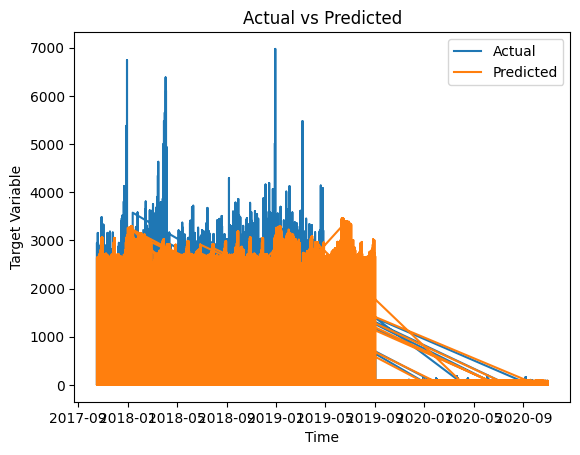

In [19]:
# Updated model
model_updated = RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=100)
model_updated.fit(X_train, y_train)

# Make predictions
y_pred = model_updated.predict(X_test)

# Evaluate the model
mae_train = mean_absolute_error(y_train, model_updated.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error Train:", mae_train)
print("Mean Absolute Error Test:", mae_test)

# Visualize predictions
plt.plot(dates_for_plot, y_test, label='Actual')
plt.plot(dates_for_plot, y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()